In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
import numpy as np

class ColorizationDataset(Dataset):
    def __init__(self, folder_path, image_size=256):
        # Grab all image paths from the folder
        valid_exts = {".jpg", ".jpeg", ".png", ".bmp"}
        self.image_paths = [
            os.path.join(folder_path, fname)
            for fname in os.listdir(folder_path)
            if os.path.splitext(fname)[1].lower() in valid_exts
        ]

        self.augment = transforms.Compose([
            transforms.RandomResizedCrop(image_size, scale=(0.8,1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            #transforms.ColorJitter(brightness=0.2, contrast=0.2),
        ])
        self.resize = transforms.Resize((image_size, image_size))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize((0.5,), (0.5,))
        self.normalize_rgb = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.augment(img)
        img = self.resize(img)

        # Grayscale and edge map
        gray = img.convert("L")
        gray_np = np.array(gray)
        edge_np = cv2.Canny(gray_np, threshold1=100, threshold2=200)
        edge_np = edge_np / 255.0  # normalize to [0, 1]

        gray_tensor = self.to_tensor(gray)
        edge_tensor = torch.from_numpy(edge_np).unsqueeze(0).float()
        input_tensor = torch.cat([gray_tensor, edge_tensor], dim=0)
        input_tensor = self.normalize(input_tensor)

        target_tensor = self.to_tensor(img)
        target_tensor = self.normalize_rgb(target_tensor)

        return input_tensor, target_tensor


In [2]:
from torch.utils.data import DataLoader

dataset = ColorizationDataset("./train", image_size=256)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

for inputs, targets in dataloader:
    print(inputs.shape)   # [B, 2, H, W]
    print(targets.shape)  # [B, 3, H, W]
    break

torch.Size([16, 2, 256, 256])
torch.Size([16, 3, 256, 256])


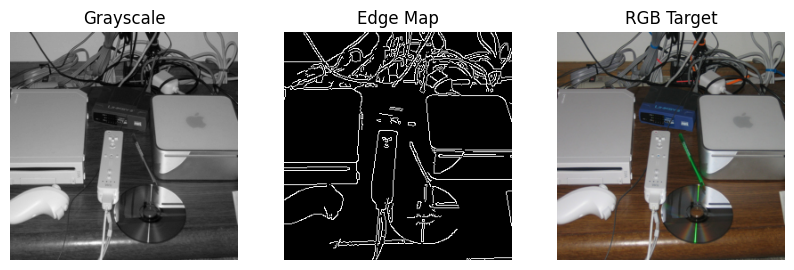

In [3]:
import matplotlib.pyplot as plt

def show_sample(input_tensor, target_tensor):
    gray = input_tensor[0].numpy()
    edge = input_tensor[1].numpy()
    rgb = target_tensor.permute(1, 2, 0).numpy()
    rgb = (rgb * 0.5 + 0.5).clip(0, 1)

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].imshow(gray, cmap='gray'); axs[0].set_title("Grayscale")
    axs[1].imshow(edge, cmap='gray'); axs[1].set_title("Edge Map")
    axs[2].imshow(rgb); axs[2].set_title("RGB Target")
    for ax in axs: ax.axis('off')
    plt.show()

# Example
i = np.random.randint(10000)
sample_input, sample_target = dataset[i]
show_sample(sample_input, sample_target)

In [4]:
import torch
import torch.nn as nn

# ------------------------------
# Generator: U-Net for Colorization
# ------------------------------
class UNetGenerator(nn.Module):
    def __init__(self, in_ch=2, out_ch=3, features=64):
        super().__init__()
        # Encoder
        self.down1 = self._block(in_ch, features)        # 2 -> 64, 256->128
        self.down2 = self._block(features, features*2)   # 64->128, 128->64
        self.down3 = self._block(features*2, features*4) # 128->256, 64->32
        self.down4 = self._block(features*4, features*8) # 256->512, 32->16
        # Bottleneck: reduce spatial to 8x8, then keep channels
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*16, kernel_size=4, stride=2, padding=1),  # 512->1024, 16->8
            nn.ReLU(),
            nn.Conv2d(features*16, features*8, kernel_size=3, stride=1, padding=1),   # 1024->512, 8->8
            nn.ReLU(),
        )
        # Decoder
        self.up1 = self._upblock(features*8, features*8)   # 512->512, 8->16
        self.up2 = self._upblock(features*16, features*4)  # (512+512)->256, 16->32
        self.up3 = self._upblock(features*8, features*2)   # (256+256)->128, 32->64
        self.up4 = self._upblock(features*4, features)     # (128+128)->64, 64->128
        # Final layer to restore size
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_ch, kernel_size=4, stride=2, padding=1),  # (64+64)->3, 128->256
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def _upblock(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        e1 = self.down1(x)
        e2 = self.down2(e1)
        e3 = self.down3(e2)
        e4 = self.down4(e3)

        b = self.bottleneck(e4)

        d1 = self.up1(b)                # 8->16
        d1 = torch.cat([d1, e4], dim=1) # ->1024 channels
        d2 = self.up2(d1)               # 16->32
        d2 = torch.cat([d2, e3], dim=1) # ->512 channels
        d3 = self.up3(d2)               # 32->64
        d3 = torch.cat([d3, e2], dim=1) # ->256 channels
        d4 = self.up4(d3)               # 64->128
        d4 = torch.cat([d4, e1], dim=1) # ->128 channels

        return self.final(d4)          # 128->256

# ------------------------------
# Discriminator: PatchGAN
# ------------------------------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=5, features=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, features, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(features, features*2, 4, 2, 1, bias=False), nn.BatchNorm2d(features*2), nn.LeakyReLU(0.2),
            nn.Conv2d(features*2, features*4, 4, 2, 1, bias=False), nn.BatchNorm2d(features*4), nn.LeakyReLU(0.2),
            nn.Conv2d(features*4, features*8, 4, 1, 1, bias=False), nn.BatchNorm2d(features*8), nn.LeakyReLU(0.2),
            nn.Conv2d(features*8, 1, 4, 1, 1)  # patch output
        )

    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

# Initialize weights

def init_weights(model, mean=0.0, std=0.02):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, mean, std)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

def init_xavier(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d)):
            nn.init.xavier_normal_(m.weight)         # or xavier_normal_
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

In [5]:
import torch
import torch.nn as nn
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from tqdm import tqdm

# ------------------------------
# Configurations
# ------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
image_size = 256
batch_size = 64
lr = 5e-4
num_epochs = 40
lambda_l1 = 100

# Paths
data_path = './train'
checkpoint_dir = './checkpoints'
sample_dir = './samples'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# ------------------------------
# Data
# ------------------------------
dataset = ColorizationDataset(data_path, image_size=image_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val = ColorizationDataset('./val', image_size=image_size)
valloader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=4)


# ------------------------------
# Models
# ------------------------------
G = UNetGenerator(in_ch=2, out_ch=3).to(device)
D = PatchDiscriminator(in_ch=5).to(device)
init_weights(G)
init_weights(D)

# ------------------------------
# Loss and Optimizers
# ------------------------------
bce_loss = nn.BCEWithLogitsLoss().to(device)
l1_loss = nn.L1Loss().to(device)
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)

# ------------------------------
# Training Loop
# ------------------------------
for epoch in range(1, num_epochs + 1):
    G.train()
    train_ssim, train_psnr, n_train = 0.0, 0.0, 0
    loop = tqdm(dataloader, desc=f'Epoch [{epoch}/{num_epochs}]')
    for idx, (inp, real) in enumerate(loop):
        inp, real = inp.to(device), real.to(device)

        # Train Discriminator
        fake = G(inp)
        D_real = D(inp, real)
        D_fake = D(inp, fake.detach())
        loss_D_real = bce_loss(D_real, torch.ones_like(D_real))
        loss_D_fake = bce_loss(D_fake, torch.zeros_like(D_fake))
        loss_D = 0.5 * (loss_D_real + loss_D_fake)
        opt_D.zero_grad(); loss_D.backward(); opt_D.step()

        # Train Generator
        D_fake_for_G = D(inp, fake)
        loss_G_GAN = bce_loss(D_fake_for_G, torch.ones_like(D_fake_for_G))
        loss_G_L1 = l1_loss(fake, real) * lambda_l1
        loss_G = loss_G_GAN + loss_G_L1
        opt_G.zero_grad(); loss_G.backward(); opt_G.step()

        # update tqdm
        train_ssim += ssim_metric(fake, real).item() * inp.size(0)
        train_psnr += psnr_metric(fake, real).item() * inp.size(0)
        n_train += inp.size(0)
        loop.set_postfix(D=loss_D.item(), G=loss_G.item())
        
    G.eval()
    val_ssim, val_psnr, n_val = 0.0, 0.0, 0
    with torch.no_grad():
        for inp, vreal in valloader:
            inp, vreal = inp.to(device), vreal.to(device)
            vfake = G(inp)
            val_ssim += ssim_metric(vfake, vreal).item() * inp.size(0)
            val_psnr += psnr_metric(vfake, vreal).item() * inp.size(0)
            n_val += inp.size(0)
        val_ssim /= n_val; train_ssim /= n_train    
        val_psnr /= n_val; train_psnr /= n_train
        print(f"Epoch {epoch:03d} Train SSIM: {train_ssim:.4f}, PSNR: {train_psnr:.2f}")
        print(f"Epoch {epoch:03d} Val SSIM:   {val_ssim:.4f}, PSNR: {val_psnr:.2f}")
            
        # Denormalize images
        inp_vis = inp * 0.5 + 0.5  # 2-channel grayscale+edge, visualize separately
        fake_vis = fake * 0.5 + 0.5
        real_vis = real * 0.5 + 0.5
        # Save fake outputs
        grid_fake = make_grid(fake_vis, nrow=4, normalize=False)
        save_image(grid_fake, f'{sample_dir}/epoch{epoch:03d}_fake.png')
        # Save real targets
        grid_real = make_grid(real_vis, nrow=4, normalize=False)
        save_image(grid_real, f'{sample_dir}/epoch{epoch:03d}_real.png')

# Save checkpoints
torch.save(G.state_dict(), f'{checkpoint_dir}/G.pth')
torch.save(D.state_dict(), f'{checkpoint_dir}/D.pth')

print("Training complete!")


Epoch [1/40]: 100%|██████████| 157/157 [02:00<00:00,  1.30it/s, D=0.0163, G=16.3]


Epoch 001 Train SSIM: 0.4397, PSNR: 12.25
Epoch 001 Val SSIM:   0.6176, PSNR: 14.75


Epoch [2/40]: 100%|██████████| 157/157 [02:20<00:00,  1.12it/s, D=1.01, G=19.3]  


Epoch 002 Train SSIM: 0.6146, PSNR: 14.54
Epoch 002 Val SSIM:   0.3803, PSNR: 4.07


Epoch [3/40]: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, D=0.376, G=14.4]


Epoch 003 Train SSIM: 0.6011, PSNR: 13.52
Epoch 003 Val SSIM:   0.5077, PSNR: 9.92


Epoch [4/40]: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s, D=0.436, G=15.2]


Epoch 004 Train SSIM: 0.6148, PSNR: 13.40
Epoch 004 Val SSIM:   0.6171, PSNR: 10.45


Epoch [5/40]: 100%|██████████| 157/157 [02:19<00:00,  1.12it/s, D=0.496, G=14.2]


Epoch 005 Train SSIM: 0.6105, PSNR: 13.27
Epoch 005 Val SSIM:   0.6077, PSNR: 12.54


Epoch [6/40]: 100%|██████████| 157/157 [02:19<00:00,  1.13it/s, D=0.739, G=12.8]


Epoch 006 Train SSIM: 0.6193, PSNR: 13.31
Epoch 006 Val SSIM:   0.5925, PSNR: 12.02


Epoch [7/40]: 100%|██████████| 157/157 [02:19<00:00,  1.13it/s, D=1.22, G=13.2] 


Epoch 007 Train SSIM: 0.6242, PSNR: 13.34
Epoch 007 Val SSIM:   0.6610, PSNR: 13.65


Epoch [8/40]: 100%|██████████| 157/157 [02:15<00:00,  1.16it/s, D=0.378, G=17.7]


Epoch 008 Train SSIM: 0.6283, PSNR: 13.34
Epoch 008 Val SSIM:   0.6563, PSNR: 13.22


Epoch [9/40]: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s, D=0.361, G=16.8]


Epoch 009 Train SSIM: 0.6315, PSNR: 13.30
Epoch 009 Val SSIM:   0.6457, PSNR: 13.17


Epoch [10/40]: 100%|██████████| 157/157 [02:15<00:00,  1.16it/s, D=0.473, G=15.3]


Epoch 010 Train SSIM: 0.6324, PSNR: 13.34
Epoch 010 Val SSIM:   0.6660, PSNR: 13.97


Epoch [11/40]: 100%|██████████| 157/157 [02:18<00:00,  1.14it/s, D=0.418, G=15.5]


Epoch 011 Train SSIM: 0.6358, PSNR: 13.34
Epoch 011 Val SSIM:   0.6447, PSNR: 13.43


Epoch [12/40]: 100%|██████████| 157/157 [02:18<00:00,  1.14it/s, D=0.571, G=14.1]


Epoch 012 Train SSIM: 0.6373, PSNR: 13.40
Epoch 012 Val SSIM:   0.6414, PSNR: 12.64


Epoch [13/40]: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s, D=0.828, G=15.4]


Epoch 013 Train SSIM: 0.6370, PSNR: 13.37
Epoch 013 Val SSIM:   0.6883, PSNR: 13.99


Epoch [14/40]: 100%|██████████| 157/157 [02:16<00:00,  1.15it/s, D=0.31, G=16.6] 


Epoch 014 Train SSIM: 0.6387, PSNR: 13.40
Epoch 014 Val SSIM:   0.6627, PSNR: 13.54


Epoch [15/40]: 100%|██████████| 157/157 [02:15<00:00,  1.16it/s, D=0.607, G=14.4]


Epoch 015 Train SSIM: 0.6393, PSNR: 13.44
Epoch 015 Val SSIM:   0.6462, PSNR: 12.60


Epoch [16/40]: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s, D=0.356, G=19.1]


Epoch 016 Train SSIM: 0.6401, PSNR: 13.42
Epoch 016 Val SSIM:   0.6742, PSNR: 14.37


Epoch [17/40]: 100%|██████████| 157/157 [02:16<00:00,  1.15it/s, D=1.6, G=14.5]  


Epoch 017 Train SSIM: 0.6414, PSNR: 13.46
Epoch 017 Val SSIM:   0.6500, PSNR: 12.77


Epoch [18/40]: 100%|██████████| 157/157 [02:18<00:00,  1.13it/s, D=0.421, G=18.9]


Epoch 018 Train SSIM: 0.6450, PSNR: 13.50
Epoch 018 Val SSIM:   0.6866, PSNR: 14.00


Epoch [19/40]: 100%|██████████| 157/157 [02:18<00:00,  1.13it/s, D=0.464, G=17.7]


Epoch 019 Train SSIM: 0.6460, PSNR: 13.52
Epoch 019 Val SSIM:   0.6825, PSNR: 13.34


Epoch [20/40]: 100%|██████████| 157/157 [02:21<00:00,  1.11it/s, D=0.498, G=13.4]


Epoch 020 Train SSIM: 0.6459, PSNR: 13.56
Epoch 020 Val SSIM:   0.6347, PSNR: 12.26


Epoch [21/40]: 100%|██████████| 157/157 [02:18<00:00,  1.13it/s, D=1.44, G=13.4] 


Epoch 021 Train SSIM: 0.6488, PSNR: 13.57
Epoch 021 Val SSIM:   0.5358, PSNR: 9.21


Epoch [22/40]: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s, D=0.413, G=16.2]


Epoch 022 Train SSIM: 0.6481, PSNR: 13.58
Epoch 022 Val SSIM:   0.6864, PSNR: 13.90


Epoch [23/40]: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s, D=1.01, G=14.8] 


Epoch 023 Train SSIM: 0.6503, PSNR: 13.62
Epoch 023 Val SSIM:   0.6883, PSNR: 14.23


Epoch [25/40]: 100%|██████████| 157/157 [02:19<00:00,  1.12it/s, D=1.27, G=12.6] 


Epoch 025 Train SSIM: 0.6535, PSNR: 13.72
Epoch 025 Val SSIM:   0.6427, PSNR: 12.01


Epoch [26/40]: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s, D=0.551, G=15]  


Epoch 026 Train SSIM: 0.6557, PSNR: 13.76
Epoch 026 Val SSIM:   0.6786, PSNR: 13.30


Epoch [27/40]: 100%|██████████| 157/157 [02:15<00:00,  1.16it/s, D=1.04, G=12.1] 


Epoch 027 Train SSIM: 0.6535, PSNR: 13.72
Epoch 027 Val SSIM:   0.6930, PSNR: 13.99


Epoch [28/40]: 100%|██████████| 157/157 [02:18<00:00,  1.13it/s, D=0.586, G=17]  


Epoch 028 Train SSIM: 0.6559, PSNR: 13.80
Epoch 028 Val SSIM:   0.6590, PSNR: 12.82


Epoch [29/40]: 100%|██████████| 157/157 [02:21<00:00,  1.11it/s, D=0.649, G=14.3]


Epoch 029 Train SSIM: 0.6566, PSNR: 13.84
Epoch 029 Val SSIM:   0.6955, PSNR: 14.07


Epoch [30/40]: 100%|██████████| 157/157 [02:14<00:00,  1.16it/s, D=0.537, G=13.1]


Epoch 030 Train SSIM: 0.6566, PSNR: 13.85
Epoch 030 Val SSIM:   0.6977, PSNR: 14.19


Epoch [31/40]: 100%|██████████| 157/157 [02:19<00:00,  1.13it/s, D=0.439, G=15.8]


Epoch 031 Train SSIM: 0.6579, PSNR: 13.88
Epoch 031 Val SSIM:   0.6924, PSNR: 14.09


Epoch [32/40]: 100%|██████████| 157/157 [02:24<00:00,  1.08it/s, D=0.352, G=14.6]


Epoch 032 Train SSIM: 0.6578, PSNR: 13.97
Epoch 032 Val SSIM:   0.6921, PSNR: 13.92


Epoch [33/40]: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s, D=0.438, G=14.6]


Epoch 033 Train SSIM: 0.6596, PSNR: 14.03
Epoch 033 Val SSIM:   0.6886, PSNR: 13.88


Epoch [34/40]:  65%|██████▍   | 102/157 [01:27<00:47,  1.16it/s, D=0.263, G=14.5]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
import os
from torchvision.utils import make_grid, save_image
import torch

test_dataset = ColorizationDataset('./test', image_size=image_size)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

G = UNetGenerator(in_ch=2, out_ch=3).to(device)
G.load_state_dict(torch.load('./checkpoints/G.pth'))
G.eval()

os.makedirs('./test_outputs', exist_ok=True)

with torch.no_grad():
    for idx, (inp, real) in enumerate(test_loader):
        inp, real = inp.to(device), real.to(device)
        fake = G(inp)
        
        fake_vis = fake * 0.5 + 0.5
        real_vis = real * 0.5 + 0.5

        save_image(make_grid(fake_vis, nrow=4), f'./test_outputs/test_{idx:02d}_fake.png')
        save_image(make_grid(real_vis, nrow=4), f'./test_outputs/test_{idx:02d}_real.png')